# <center> Building a Spam Filter for SMS Messages with Naive Bayes </center>

>Spam refers to irrelevant or unsolicited messages sent over the internet, typically to a large number of users, for the purposes of advertising, phishing, spreading malware, etc. ([_source_](https://www.lexico.com/definition/spam))

Receiving SMS messages of this sort becomes increasingly annoying with frequency and a solution to this menace is often desired.

That said, the aim of this project is to develop a spam filter for SMS messages. 

The first task to achieving this is to _teach_ the computer how to classify messages by using the mulitnomial Naive Bayes algorithm. For the purpose of this project, I will do this along with a dataset of 5,572 messages that have already been classified by humans.

The dataset was put together by Tiago A. Almeida and Jose Maria Gomez Hidalgo. Should you need it, you can download the dataset from The [UCI Machine Learning Repository here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

## Exploring the Dataset

In [1]:
import pandas as pd
sms_collection = pd.read_csv('SMSSpamCollection', sep='\t', header = None, names=['Label', 'SMS'])
sms_collection.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
print('This dataset has',sms_collection.shape[0], 'rows and',sms_collection.shape[1], 'columns' )

This dataset has 5572 rows and 2 columns


In [3]:
sms_collection['Label'].value_counts(normalize = True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

About 87% of the messages are classified as non-spam messages while the remaining 13% are spam messages.

*'ham' means non-spam* **

## Splitting the Dataset: Training and Test Set

It is important to know how good the spam filter is at classifying messages by designing the test before creating the filter. 

I will get this done by splitting the dataset into 2 categories:
- A **training set** (4,458 messages: 80% of the dataset) to 'train' the computer on how to classify messages.
- A **test set** (1,114 messages: 20% of the dataset) to test the efficiency of the spam filter in classifying new messages.

A large proportion of the dataset is going into the training set because I'll like to train the algorithm with as much data as possible

Meanwhile, the concept of setting aside the test data is to analyze the efficiency of the filter to correctly classify a message that, if you recall, has already been classified by a human.

**Note: A filter 80% accuracy is the desired outcome.**

First, I will randomize the entire dataset to ensure that spam and ham messages are well-spread throughout the dataset.

In [4]:
randomized_sms = sms_collection.sample(frac=1, random_state=1)

Next, I'll assign 80% of the randomized dataset to `train_data` and 20% to `test_data`.

In [5]:
#splitting randomized dataset
train_data = randomized_sms.head(4458)
test_data = randomized_sms.tail(1114)

#resetting the index labels
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [6]:
#Proportion of spam and ham in train_data
train_data['Label'].value_counts(normalize = True)*100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [7]:
#Proportion of spam and ham in test_data
test_data['Label'].value_counts(normalize = True)*100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

<u>**Observation**</u>

The proportion of spam and ham messages in both the training and the test set are similar to what we observed in the full dataset (87% : 13%). This means the samples are representative of the population. Good to go!

## Data Cleaning: Letter Case and Punctuation

Having split the dataset into training and test set, the next step is to use the training set to teach the algorithm to classify new messages.

But before that, I need to clean up the data in the `SMS` columns to bring it to a format that makes it easy to extract the information I need.

In [8]:
train_data.head(5)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


I'll begin the data cleaning by removing punctuations in the messages and changing all the words to lowercase. So, `Haven't` and `havent`, for instance, will be treated the same way.

In [9]:
#removing punctuation and changing to lowercase
train_data['SMS'] = train_data['SMS'].str.replace('\W',' ').str.lower()

In [10]:
train_data.head(5)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating the Vocabulary for the Naive Bayes Algorithm

To classify the messages, the Naive Bayes algorithm will need to know the probability values of these two formulas:

<img src="files/image_1.PNG" />
<img src="files/image_2.PNG" />


However, the following equations will be necessary to calculate P(wi|Spam) and P(wi|Ham) in the formulas above:

<img src="files/image_3.PNG" />

<img src="files/image_4.PNG" />

Here's a summary of what the terms in the equations above mean:

<img src="files/image_5.PNG" />

I'll need to do a bit of data cleaning first to calculate these probabilities. That being said, the end goal with the data cleaning process is to bring the `train_set` to this format:

![title](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)

From the image above, except the `Label column`, every other column in the table represents the frequency of unique words in a set vocabulary. 

**Note**:*A vocabulary is a list with all the unique words that occur in the messages from the training set*

I'll start by creating my vocabulary in order to bring the training set to the format in the image.

In [11]:
#transforming each message in the SMS column into a list of words
train_data['SMS'] = train_data['SMS'].str.split() 
train_data.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [12]:
#Creating the vocabulary
vocabulary = []
for message in train_data['SMS']:
    for word in message:
        vocabulary.append(word)
len(vocabulary)

72427

In [13]:
#transforiming vocabulary to a set to remove duplicates
vocabulary = set(vocabulary)
len(vocabulary)

7783

Now that the `vocabulary` is comprised of only unique words from the training set, I'll transform it from a set back into a list. 

In [14]:
vocabulary = list(vocabulary)
vocabulary[:10]

['nalla',
 'host',
 'outrageous',
 'handing',
 'lotsly',
 'clearer',
 'frens',
 'motorola',
 'or2stoptxt',
 'tease']

## Final Training Set

Recall that the goal is to bring the `training set` to this format:

![title](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)

To achieve this, I'll eventually need to build a dictionary which I'll then transform into a new DataFrame.

The keys in the dictionary will be the unique words from `vocabulary` while the values with be a corresponding list of the the length of the training set.

In [15]:
#creating new dictionary
word_counts_per_sms = {unique_word: [0] * len(train_data['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(train_data['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [16]:
#transforming word_count_per_sms into a DataFrame
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,nalla,host,outrageous,handing,lotsly,clearer,frens,motorola,or2stoptxt,tease,...,sppok,waz,small,morphine,sony,showers,treacle,ans,0800,plm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, I'll concatenate the new DataFrame with the DataFrame containing the training set.

In [17]:
train_data_clean = pd.concat([train_data, word_counts], axis=1)
train_data_clean.head()

,Label,SMS,nalla,host,outrageous,handing,lotsly,clearer,frens,motorola,...,sppok,waz,small,morphine,sony,showers,treacle,ans,0800,plm
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calulating Constants First

Recall these equations:
<img src="files/image_1.PNG" />

<img src="files/image_2.PNG" />

...and these:

<img src="files/image_3.PNG" />

<img src="files/image_4.PNG" />


There are values in these formulas that will remain the same for every new message. 

So, using only the training set, I'll calculate these following constant values first:
- P(Spam) and P(Ham)
- NSpam, NHam, NVocabulary


I'll also use Laplace smoothing and 
set &alpha; = 1


In [18]:
spam_messages = train_data_clean[train_data_clean['Label'] == 'spam']
ham_messages = train_data_clean[train_data_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_data_clean)
p_ham = len(ham_messages) / len(train_data_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

Having calculated the constant values, the next step is to calculate the parameters P(wi|Spam) and P(wi|Ham). 

<img src="files/image_3.PNG" />

<img src="files/image_4.PNG" />

Recall that these parameters are important parts of the equations we will need to classify new messages.

In the next block of code, we will calculate P(wi|Spam) as `parameters_spam` and P(wi|Ham) as `parameters_ham`.

In [19]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum() 
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum() 
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham


## Classifying a New Message

Now that I have all the parameters and constants, I can finally get to the purpose of this project - build a spam filter for SMS messages.

The spam filter can best be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn)
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
 - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
 - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
 - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.
 
The next block of code describes the logic of the spam filter.

In [20]:
def classify(message):

    message = message.str.replace('\W',' ')
    message = message.lower()
    message = message.split()

    '''    
    placeholder to calculate:

    p_spam_given_message = ?
    p_ham_given_message = ?
    '''    

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Message Type: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Message Type: Spam')
    else:
        print('Equal proabilities, a human needs to classify this!')

The `classify()` function in the code above:
- Takes in a `message` it assumes to be a string
- Performs data cleaning on the string
- Calculates `p_spam_given_message` and `p_ham_given_message`
- Compares `p_spam_given_message` and `p_ham_given_message` and then prints a classification label. 


Note that some new messages may contain words that are not part of the vocabulary of unique words. This filter will ignore such words when calculating probabilities. 

I'll complete the code and test how well the function classifies a new message...

In [21]:
import re 
def classify(message):

    message = re.sub('\W',' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Message Type: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Message Type: Spam')
    else:
        print('Equal proabilities, a human needs to classify this!')

Let's test the filter with an obvious spam message and an obvious ham (non-spam) message.

In [22]:
classify('CONGRATULATIONS You have been selected as the winner. Text your BVN to 33567 to claim your prize!')

P(Spam|message): 6.857114321373393e-38
P(Ham|message): 2.0472365845343654e-46
Message Type: Spam


In [23]:
classify('Hey, Sam! Can u send the plumber\'s number? Thanks')

P(Spam|message): 7.0922786485345535e-28
P(Ham|message): 3.65592622413323e-25
Message Type: Ham


Looks like the spam filter works perfectly. Nonetheless, I'll test its accuracy in the next section. Recall that the desired accuracy is 80%.

## Measuring the Spam Filter's Accuracy

I will run the `test data` through the filter to test the filter's accuracy. The filter is going to treat each message in the datset as a new message because the algorithm never saw the dataset.

A little modification to the previous function will provide a function that returns labels for each message instead of printing them. I'll then use the labels to create a column in the `test_data`.

In [24]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

test_data['predicted'] = test_data['SMS'].apply(classify_test_set)
test_data.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


I can now compare the actual values in the dataset to the predicted values to measure the accuracy of the spam filter by using the formula below:

<img src="files/image_6.PNG" />

In [25]:
correct = 0
total = test_data.shape[0]

for row in test_data.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', round(correct/total * 100, 2),'%')    

Correct: 1100
Incorrect: 14
Accuracy: 98.74 %


A 98.74% accuracy is really good especially because it exceeds the expected 80% accuracy value!

## Next Steps

I have successfully built a spam filter that has a really good accuracy of 98.74% - an accuracy that exceeds expectation.

However, I'm also interested in the 14 messages that were wrongly classified and will like to find out why they didn't make it to the majority.

I'll start by isolating rows in `test_data` that were wrongly predicted.

In [26]:
def clean(message):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    
    return message

test_data['SMS'] = test_data['SMS'].apply(clean)
incorrect_classification = test_data[test_data['Label'] != test_data['predicted']]
incorrect_classification

,Label,SMS,predicted
114,spam,not heard from u4 a while call me now am here...,ham
135,spam,more people are dogging in your area now call...,ham
152,ham,unlimited texts limited minutes,spam
159,ham,26th of july,spam
284,ham,nokia phone is lovly,spam
293,ham,a boy loved a gal he propsd bt she didnt mind...,needs human classification
302,ham,no calls messages missed calls,spam
319,ham,we have sent jd for customer service cum accou...,spam
504,spam,oh my god i ve found your number again i m s...,ham
546,spam,hi babe its chloe how r u i was smashed on s...,ham


Let's view this in a word cloud to appreciate the information better. 

We'll start with ham(non-spam) messages that were wrongly classified as spam messages.

### Investigatin Wrongly Classified `ham` (non-spam) Messages

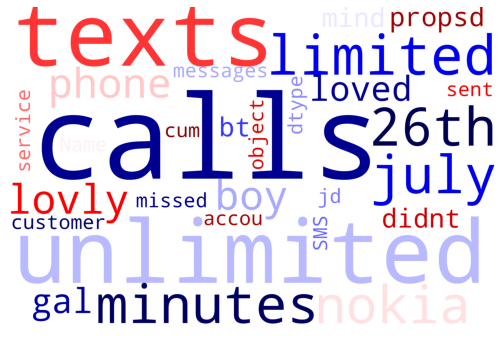

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(18, 6))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Generate word cloud
from wordcloud import WordCloud, STOPWORDS
text_in_ham = incorrect_classification[incorrect_classification['Label'] == 'ham']
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', 
                      colormap='seismic', collocations=False, stopwords = STOPWORDS).generate(str(text_in_ham['SMS']))
# Plot
plot_cloud(wordcloud)



Some of the common words here are 'texts', 'calls', 'unlimited', and 'limited'. These are words commonly found in spam messages. So, a likely reason that the filter wrongly classified this ham messages as spam messages is that they contain words that are similar to words in spam messages. 

This factor will affect the value of the `p_spam_given_message` of a message in this category and cause it to be higher than the value of `p_ham_given_message` which will assign the value 'spam' to the message.

In [28]:
words_1 = str(text_in_ham['SMS']).split()
num_words_1 = len(words_1)

not_in_vocab_1 = 0
for word in words_1:
    if word not in vocabulary:
        not_in_vocab_1 +=1

print('Total number of words not in vocabulary:',not_in_vocab_1)
print('Total number of words in messages:',num_words_1)
print('Percentage of words not in vocabulary:', round(not_in_vocab_1/num_words_1 * 100 , 2),'%')

Total number of words not in vocabulary: 14
Total number of words in messages: 46
Percentage of words not in vocabulary: 30.43 %


The fact that 14 out of 46 words in these messages are not in the vocabulary is likely to affect the calculation and is also a likely reason that some of these messages are wrongly classified.

Let's check out the spam messages that were wrongly classified as ham.

### Investigating Wrongly Classified `Spam` Messages

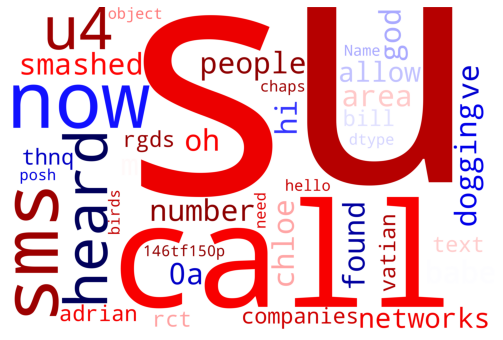

In [29]:
# Generate word cloud
from wordcloud import WordCloud, STOPWORDS
text_in_spam = incorrect_classification[incorrect_classification['Label'] == 'spam']
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', 
                      colormap='seismic', collocations=False, stopwords = STOPWORDS).generate(str(text_in_spam['SMS']))
# Plot
plot_cloud(wordcloud)

The word cloud shows the most frequent words like 'heard', 'call', 'found', and 'people' in the wrongly classified spam messages. These are words typically found in ham messages. This is a probable reason for the wrong classification as 'ham'.

Meanwhile, there are also words in these messages that are not present in the vocabulary. Recall that words that are not present in the vocabulary where ignored during the calculations.

Let's find out how many of such words are present here.

In [30]:
words_2 = str(text_in_spam['SMS']).split()
num_words_2 = len(words_2)

not_in_vocab_2 = 0
for word in words_2:
    if word not in vocabulary:
        not_in_vocab_2 +=1

print('Total number of words not in vocabulary:',not_in_vocab_2)
print('Total number of words in messages:',num_words_2)
print('Percentage of words not in vocabulary:', round(not_in_vocab_2/num_words_2 * 100 , 2),'%')

Total number of words not in vocabulary: 29
Total number of words in messages: 86
Percentage of words not in vocabulary: 33.72 %


29 out of 86 words (about 34%) in the wrongly classified spam messages are not in the vocabulary. For messages with such words (which will be ignored), the ham words will outweigh the spam words and contribute to `p_ham_given_message` being greater than `p_spam_given_message`.

## Conclusion

A spam filter for SMS messages was successfully built by running a training set of 4,458 messages through the Naive Bayes algorithm. A test on the filter's accuracy using the test set of 1,114 messages revealed a filter accuracy of 98.74% -- a really good accuracy value that exceeded the desired 80% accurracy.

Of the 1,114 messages that were tested, 14 of them were wrongly classified. A further investigation into these messages hinted that the misclassification may be due to:
- Typical spam words being present in ham messages and vice versa
- Messages containing certain words that are not present in the vocabulary and will have been ignored in the calculations.

Any message that checks one or both of these factors will have inaccurate `p_ham_given_message` and `p_spam_given_message` values and will be wrongly classified.

_**Yeside Okelana**_